          throughput_op_s  mean_ms  median_ms  p95_ms  p99_ms  max_ms
loss_pct                                                             
2                 55709.0      0.9        0.4     1.4     5.2   953.2
3                 46572.0      1.0        0.3     1.0     5.8  1480.6
4                 36046.0      1.4        0.3     0.8     5.9  3290.4
5                 26488.0      1.8        0.2     0.7     7.7  1645.2
6                 19181.0      2.5        0.2     0.6    58.0  3114.3
7                 14578.0      3.4        0.2     0.7   196.1  3143.6
8                 10791.0      4.6        0.2     0.8   205.7  1668.3
9                  8999.0      5.5        0.2     0.9   206.6  3168.8
10                 7105.0      7.0        0.2     1.6   207.5  3143.6


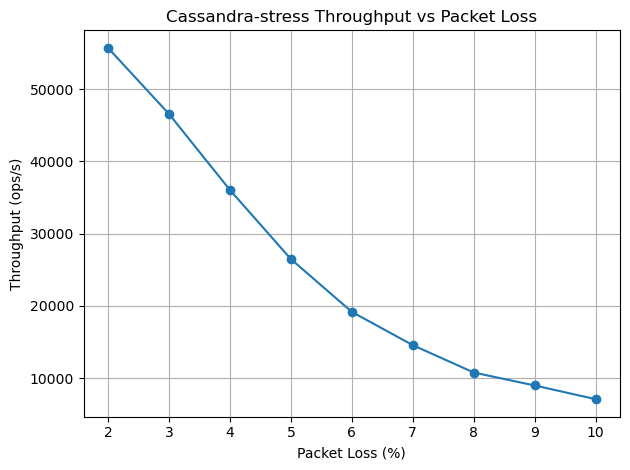

<Figure size 640x480 with 0 Axes>

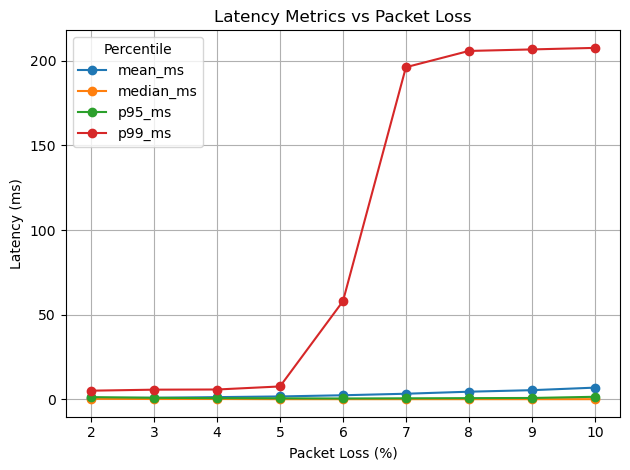

In [1]:
import os
import re
import pandas as pd
import matplotlib.pyplot as plt

# ─────────── CONFIG ───────────
# Point this at your local folder containing loss2/, loss3/, … loss10/
base_dir = r"C:\cassandra-outputs"

# ─────────── PARSER ───────────
def parse_metrics(log_path):
    """
    Extracts the final summary metrics from a cassandra-stress log.
    Returns a dict with keys: 'ops_per_s', 'mean_ms', 'median_ms', 'p95_ms', 'p99_ms', 'max_ms'.
    """
    metrics = {}
    with open(log_path, 'r', encoding='utf-8', errors='ignore') as f:
        text = f.read()

    # Final summary block starts with "Results:"; we grab the lines below
    block = text.split("Results:")[-1]
    for line in block.splitlines():
        if ':' not in line:
            continue
        name, val = line.split(":", 1)
        name = name.strip()
        val = val.strip().split()[0].replace(',', '')  # remove commas
        try:
            metrics[name] = float(val)
        except ValueError:
            pass

    return {
        'throughput_op_s': metrics.get('Op rate', None),
        'mean_ms':         metrics.get('Latency mean', None),
        'median_ms':       metrics.get('Latency median', None),
        'p95_ms':          metrics.get('Latency 95th percentile', None),
        'p99_ms':          metrics.get('Latency 99th percentile', None),
        'max_ms':          metrics.get('Latency max', None),
    }

# ─────────── COLLECT DATA ───────────
rows = []
for loss in range(2, 11):
    loss_dir = os.path.join(base_dir, f"loss{loss}")
    log_file = os.path.join(loss_dir, f"loss{loss}_cassandra-stress.log")
    if not os.path.exists(log_file):
        print(f"⚠️  Missing file: {log_file}")
        continue
    m = parse_metrics(log_file)
    m['loss_pct'] = loss
    rows.append(m)

df = pd.DataFrame(rows).sort_values('loss_pct').set_index('loss_pct')
print(df)

# ─────────── PLOT ───────────
plt.figure()
df['throughput_op_s'].plot(marker='o')
plt.title("Cassandra‑stress Throughput vs Packet Loss")
plt.xlabel("Packet Loss (%)")
plt.ylabel("Throughput (ops/s)")
plt.grid(True)
plt.tight_layout()

plt.figure()
df[['mean_ms','median_ms','p95_ms','p99_ms']].plot(marker='o')
plt.title("Latency Metrics vs Packet Loss")
plt.xlabel("Packet Loss (%)")
plt.ylabel("Latency (ms)")
plt.legend(title="Percentile")
plt.grid(True)
plt.tight_layout()

plt.show()


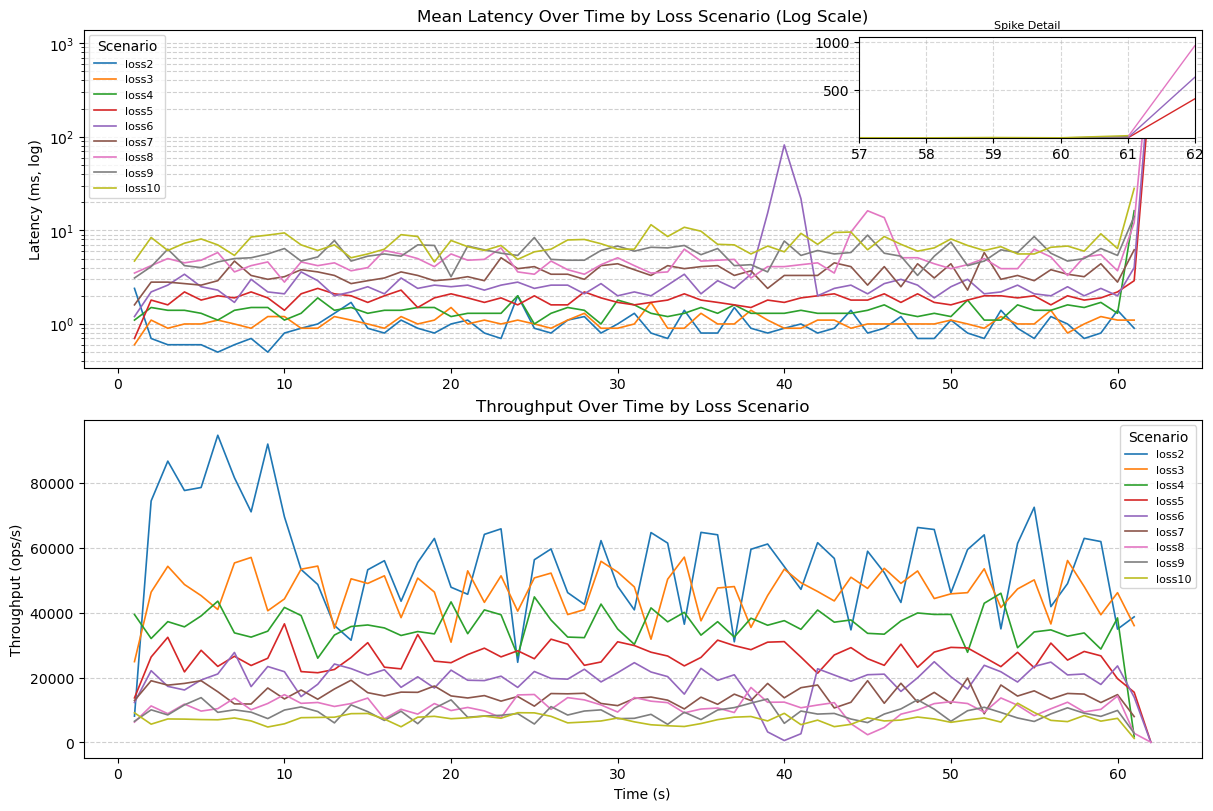

In [13]:
import os
import glob
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

# ─────────── CONFIG ───────────
base_dir = r"C:\cassandra-outputs"
scenarios = [f"loss{n}" for n in range(2, 11)]

# ─────────── LOAD TIME‑SERIES DATA ───────────
ts_data = {}
for sc in scenarios:
    # match any folder containing the scenario name
    pattern = os.path.join(base_dir, f"*{sc}")
    matches = glob.glob(pattern)
    if not matches:
        print(f"⚠️  no folder for {sc}")
        continue

    run_dir = matches[-1]
    log_file = os.path.join(run_dir, f"{sc}_cassandra-stress.log")
    if not os.path.isfile(log_file):
        print(f"⚠️  no log at {log_file}")
        continue

    times, throughputs, lats = [], [], []
    with open(log_file, 'r', encoding='utf-8', errors='ignore') as f:
        idx = 0
        for line in f:
            if not line.startswith("total,"):
                continue
            parts = line.strip().split(",")
            idx += 1
            times.append(idx)
            throughputs.append(float(parts[2]))
            lats.append(float(parts[5]))

    ts_data[sc] = pd.DataFrame({
        "time_s":      times,
        "throughput":  throughputs,
        "mean_lat_ms": lats
    })

# ─────────── PLOT ───────────
fig = plt.figure(figsize=(12, 8), constrained_layout=True)

# Latency subplot (log scale)
ax1 = fig.add_subplot(2, 1, 1)
for sc, df in ts_data.items():
    ax1.plot(df.time_s, df.mean_lat_ms, label=sc, linewidth=1.2)
ax1.set_yscale('log')
ax1.set_title("Mean Latency Over Time by Loss Scenario (Log Scale)")
ax1.set_ylabel("Latency (ms, log)")
ax1.legend(title="Scenario", fontsize=8, loc="upper left")
ax1.grid(axis='y', which='both', linestyle='--', alpha=0.6)

# Inset zoom on the final spike region
max_spike_df = max(ts_data.values(), key=lambda d: d['mean_lat_ms'].max())
axins = inset_axes(ax1, width="30%", height="30%", loc='upper right')
for sc, df in ts_data.items():
    axins.plot(df.time_s, df.mean_lat_ms, linewidth=1.0)
last_times = max_spike_df.time_s.values
last_lats  = max_spike_df.mean_lat_ms.values
axins.set_xlim(last_times[-6], last_times[-1])
axins.set_ylim(max(1, min(last_lats[-5:])), max(last_lats[-5:]) * 1.1)
axins.set_title("Spike Detail", fontsize=8)
axins.grid(True, linestyle='--', alpha=0.5)

# Throughput subplot
ax2 = fig.add_subplot(2, 1, 2)
for sc, df in ts_data.items():
    ax2.plot(df.time_s, df.throughput, label=sc, linewidth=1.2)
ax2.set_title("Throughput Over Time by Loss Scenario")
ax2.set_xlabel("Time (s)")
ax2.set_ylabel("Throughput (ops/s)")
ax2.legend(title="Scenario", fontsize=8, loc="upper right")
ax2.grid(axis='y', linestyle='--', alpha=0.6)

plt.show()
